# Network lab

For this lab, we will be using fMRI connectivity data from http://umcd.humanconnectomeproject.org/, and analyzing the network of correlations between brain areas.

In [1]:
import numpy as np   # For matrix/array handling
import matplotlib
import matplotlib.pyplot as plt   # For plotting
import networkx as nx   # For network analysis
from itertools import izip
from sklearn import cluster
%matplotlib inline

## Choosing a network

In [4]:
# First, let's load in the correlations matrix.
graph_loc = "ADHD200_CC200_KKI_2371032_connectmat.txt"
with open(graph_loc) as fgraph:
    for i,line in enumerate(fgraph):
        row = np.array(map(float, line.strip().split()))
        if i == 0:    # Set up the graph on our first pass through
            N = len(row)
            np_network = np.zeros((N,N), dtype=float)
        np_network[i,:] = row

print "Created %d-user network, average correlation: %f" %(N, np.mean(np_network))
print "Min correlation: %f\tMax correlation: %f" %(np.min(np_network), np.max(np_network))
print "Mean correlation: %f\tMedian correlation: %f" %(np.mean(np_network), np.median(np_network))

Created 190-user network, average correlation: 0.006827
Min correlation: -0.840503	Max correlation: 0.959508
Mean correlation: 0.006827	Median correlation: 0.000000


As you can see, correlations between areas varies a lot; however, most network analysis techniques become easier if we have a binary network. So we need to decide on a threshold--a correlation value above which we consider the correlation to be enough to draw an edge. There are tradeoffs in this decision--if we set the threshold very low, we will have an almost complete graph with no structure, but if we set the threshold very high, we will have an almost empty graph with no structure. Let's investigate how many edges we would have with various thresholds. Note that all thresholds ignore negative correlations, which did exist in the original data. We ignore them for now, but a more in-depth analysis would treat negative correlations and positive correlations as two different kinds of edges, resulting in a <b>heterogeneous network</b>.

In [5]:
# Try out various thresholds
threshs = map(lambda x: x*.1, range(10))
for thresh in threshs:
    nonzeros = np.nonzero(np_network > thresh)[0]  # Threshold the network, and count the non-zero edges
    print "At threshold %f, we have %d of %d potential edges" %(thresh, len(nonzeros)/2, (N**2 - N)/2)

At threshold 0.000000, we have 9023 of 17955 potential edges
At threshold 0.100000, we have 7020 of 17955 potential edges
At threshold 0.200000, we have 5197 of 17955 potential edges
At threshold 0.300000, we have 3567 of 17955 potential edges
At threshold 0.400000, we have 2230 of 17955 potential edges
At threshold 0.500000, we have 1291 of 17955 potential edges
At threshold 0.600000, we have 631 of 17955 potential edges
At threshold 0.700000, we have 252 of 17955 potential edges
At threshold 0.800000, we have 68 of 17955 potential edges
At threshold 0.900000, we have 9 of 17955 potential edges


To observe how our results change as a result of different thresholds, we will work with two networks going forward: one thresholded at .4 and one thresholded at .7.

In [6]:
# Now, build our graph in networkx so we can start analyzing it!
thresh_net_4 = np_network > .4
thresh_net_7 = np_network > .7

G4 = nx.Graph()
rows,cols = thresh_net_4.nonzero()
for row,col in izip(rows,cols):  # Note this will add each edge twice, but networkx will just ignore redundant edges
    G4.add_edge(row,col)
print "Created a networkx graph with %d nodes and %d edges"  %(len(G4.nodes()), len(G4.edges()))  # Make sure it's the right size

G7 = nx.Graph()
rows,cols = thresh_net_7.nonzero()
for row,col in izip(rows,cols):
    G7.add_edge(row,col)
print "Created a networkx graph with %d nodes and %d edges"  %(len(G7.nodes()), len(G7.edges()))

Created a networkx graph with 190 nodes and 2230 edges
Created a networkx graph with 127 nodes and 252 edges


## Degree distribution and centrality
Now that we have our network, we can start analyzing its properties. The first thing you may want to do is visualize the network, but unfortunately, this doesn't tell you a whole lot on its own. Note that the network visualization algorithm is stochastic--if you want, you can run this block several times and get slightly different visualizations.

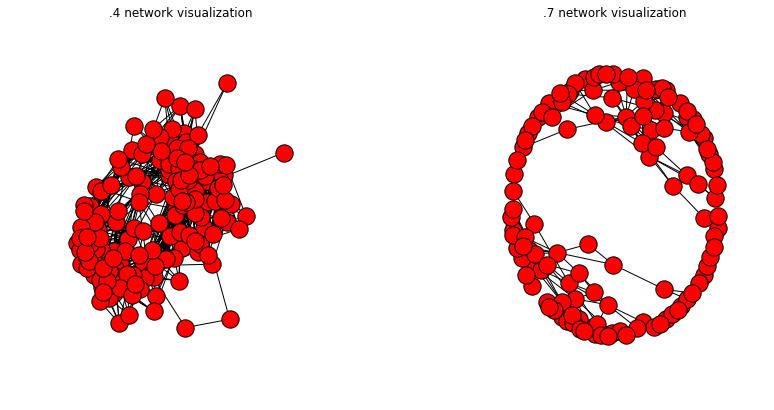

In [7]:
# Visualize the networks
fig, axs = plt.subplots(ncols=2)  # Make side-by-side plots, like MATLAB's subplot function
fig.subplots_adjust(right=1.8, wspace=.5, top=1.4)  # This allows us to make the subplots bigger and more spaced out
nx.draw(G4,ax=axs[0])
axs[0].set_title(".4 network visualization")
nx.draw(G7,ax=axs[1])
axs[1].set_title(".7 network visualization")

This tells us some things:  in the .7 network, most nodes just link to a few other nodes, but not in a way that forms coherent clusters. We see stronger interconnections in the .4 network. However, in both visualizations, most of the nodes just seem to be on top of each other. So we will need to find other ways to understand what's going on, some of which will aid us in visualization. One of the first things to look at is the degree distribution--how many nodes does each node connect to?

Min/mean/median/max degree (.4 network):	1	23.473684	23.000000	51
Min/mean/median/max degree (.7 network):	1	3.968504	3.000000	16


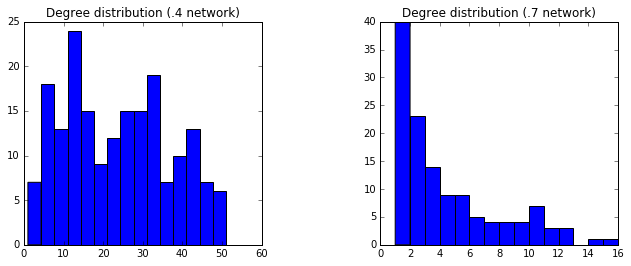

In [8]:
# Get degree distribution
degree_dict4 = nx.degree(G4)  # Returns a dictionary from node name to node degree
degree_arr4 = np.array(degree_dict4.values())  # Put this into a numpy array for easier analysis
print "Min/mean/median/max degree (.4 network):\t%d\t%f\t%f\t%d" %(np.min(degree_arr4), np.mean(degree_arr4),
                                                     np.median(degree_arr4), np.max(degree_arr4))
degree_dict7 = nx.degree(G7)  # Returns a dictionary from node name to node degree
degree_arr7 = np.array(degree_dict7.values())  # Put this into a numpy array for easier analysis
print "Min/mean/median/max degree (.7 network):\t%d\t%f\t%f\t%d" %(np.min(degree_arr7), np.mean(degree_arr7),
                                                     np.median(degree_arr7), np.max(degree_arr7))
# And let's make a histogram
fig, axs = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=.5, right=1.5)
axs[0].hist(degree_arr4, bins=15)
axs[0].set_title("Degree distribution (.4 network)")
axs[1].hist(degree_arr7, bins=15)
axs[1].set_title("Degree distribution (.7 network)")
plt.show()

We can glean a few things from this analysis. As we would expect, the .4-thresholded network has nodes with many more connections than the .7 network. Interestingly, we see that the degree distribution in the .4 network isn't particularly skewed--there are some more nodes in the low-degree part of the graph than the high-degree part, but it isn't that clear. However, the .7 network shows a clear power law degree distribution: we have many nodes with only 1 or 2 edges, and the amount of nodes with higher numbers of edges decays exponentially. This power law pattern is very common in many network settings--anywhere where you have a few popular nodes and many not-as-popular nodes will result in this pattern.

This transitions us nicely into the concept of <b>network centrality</b>. In any network, we may want to know who the most important nodes are, but how do we define "important"? We've already seen one way--by the degree of an edge. However, there are other ways that we will investigate.

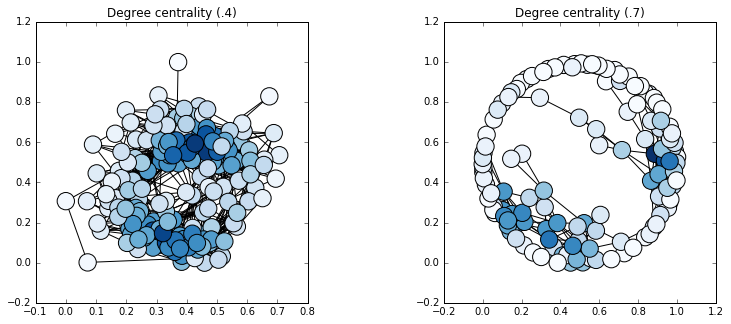

In [9]:
# First, we look at degree centrality, which says that a node is as important as its connections
np.random.seed(11)  # Hold the random seed fixed so we always generate the same graph
fig,axs = plt.subplots(ncols=2)
fig.subplots_adjust(right=1.7, wspace=.5, top=1.1)
degree_centrality_4 = nx.degree_centrality(G4)
nx.draw_networkx(G4,with_labels=False, nodelist=degree_centrality_4.keys(), node_color=degree_centrality_4.values(),
                 cmap=plt.get_cmap('Blues'), ax=axs[0])   # Color the nodes by centrality value
axs[0].set_title("Degree centrality (.4)")
degree_centrality_7 = nx.degree_centrality(G7)
nx.draw_networkx(G7,with_labels=False, nodelist=degree_centrality_7.keys(), node_color=degree_centrality_7.values(),
                 cmap=plt.get_cmap('Blues'), ax=axs[1])   # Color the nodes by centrality value
axs[1].set_title("Degree centrality (.7)")
plt.show()

However, degree centrality misses a lot: am I really more central to the network if I'm connected to 50 unimportant people than if I'm connected to 2 very important ones? We ahve three other standard measures of centrality that attempt to overcome this defecit:
1. Betweenness centrality: This looks at how important a "bridge" a node is between other nodes. It is computed by looking at the number of shortest paths between edges in the network pass through this one, so it will be higher if many nodes need to pass through this node on their shortest paths to other nodes.
2. Closeness centrality: This says that a node is more central if it has lower "degrees of separation" from most nodes in the network. It is computed as 1 over the average distance on the grahp from this node to all the others in the network.
3. Eigenvector centrality: This is essentially equivalent to the PageRank algorithm that Google uses to rank the importance of websites. It says that a node is important if it is connected to other important nodes in the network.

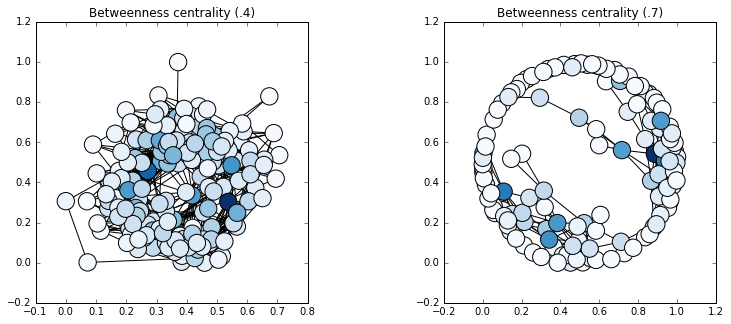

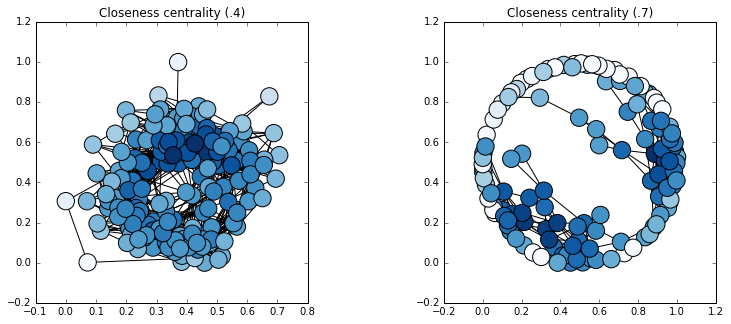

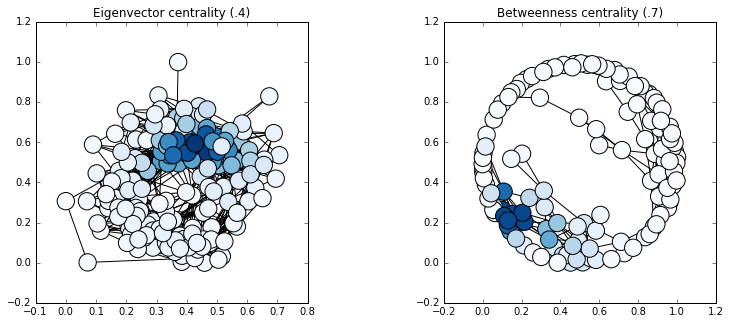

In [10]:
np.random.seed(11)
fig,axs = plt.subplots(ncols=2)
fig.subplots_adjust(right=1.7, wspace=.5, top=1.1)
betweenness_centrality_4 = nx.betweenness_centrality(G4)
nx.draw_networkx(G4,with_labels=False, nodelist=betweenness_centrality_4.keys(), node_color=betweenness_centrality_4.values(),
                 cmap=plt.get_cmap('Blues'), ax=axs[0])   # Color the nodes by centrality value
axs[0].set_title("Betweenness centrality (.4)")
betweenness_centrality_7 = nx.betweenness_centrality(G7)
nx.draw_networkx(G7,with_labels=False, nodelist=betweenness_centrality_7.keys(), node_color=betweenness_centrality_7.values(),
                 cmap=plt.get_cmap('Blues'), ax=axs[1])   # Color the nodes by centrality value
axs[1].set_title("Betweenness centrality (.7)")
plt.show()

np.random.seed(11)
fig,axs = plt.subplots(ncols=2)
fig.subplots_adjust(right=1.7, wspace=.5, top=1.1)
closeness_centrality_4 = nx.closeness_centrality(G4)
nx.draw_networkx(G4,with_labels=False, nodelist=closeness_centrality_4.keys(), node_color=closeness_centrality_4.values(),
                 cmap=plt.get_cmap('Blues'), ax=axs[0])   # Color the nodes by centrality value
axs[0].set_title("Closeness centrality (.4)")
closeness_centrality_7 = nx.closeness_centrality(G7)
nx.draw_networkx(G7,with_labels=False, nodelist=closeness_centrality_7.keys(), node_color=closeness_centrality_7.values(),
                 cmap=plt.get_cmap('Blues'), ax=axs[1])   # Color the nodes by centrality value
axs[1].set_title("Closeness centrality (.7)")
plt.show()


np.random.seed(11)
fig,axs = plt.subplots(ncols=2)
fig.subplots_adjust(right=1.7, wspace=.5, top=1.1)
eigenvector_centrality_4 = nx.eigenvector_centrality(G4,max_iter=200)  # specify max_iter or else it doesn't converge
nx.draw_networkx(G4,with_labels=False, nodelist=eigenvector_centrality_4.keys(), node_color=eigenvector_centrality_4.values(),
                 cmap=plt.get_cmap('Blues'), ax=axs[0])   # Color the nodes by centrality value
axs[0].set_title("Eigenvector centrality (.4)")
eigenvector_centrality_7 = nx.eigenvector_centrality(G7)
nx.draw_networkx(G7,with_labels=False, nodelist=eigenvector_centrality_7.keys(), node_color=eigenvector_centrality_7.values(),
                 cmap=plt.get_cmap('Blues'), ax=axs[1])   # Color the nodes by centrality value
axs[1].set_title("Betweenness centrality (.7)")
plt.show()

Some differences between the types of centrality are clear from the diagrams, but not a whole lot. One thing we can do to make the differences clearer is plot the different kinds of centrality against each other

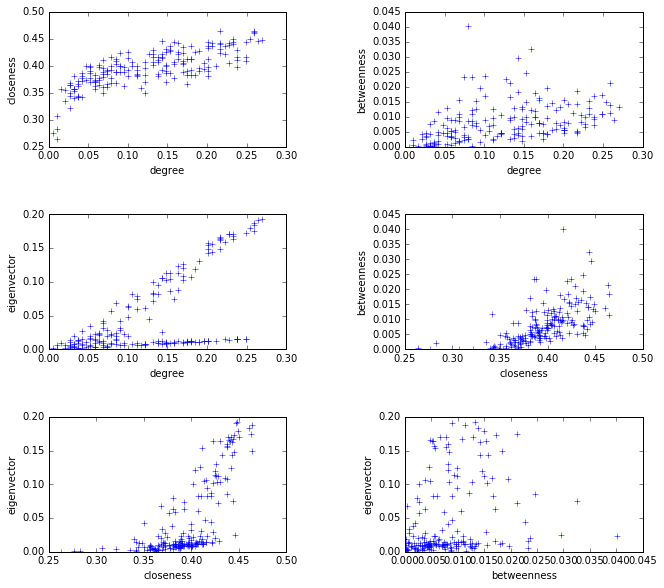

In [11]:
degree_vec_4 = np.array([value for key,value in sorted(degree_centrality_4.items())])
closeness_vec_4 = np.array([value for key,value in sorted(closeness_centrality_4.items())])
betweenness_vec_4 = np.array([value for key,value in sorted(betweenness_centrality_4.items())])
eigenvector_vec_4 = np.array([value for key,value in sorted(eigenvector_centrality_4.items())])

# Now, print all 6 pairwise plots
plt.subplot(321)
plt.subplots_adjust(wspace=.5,hspace=.5, right=1.5, top=2)
plt.plot(degree_vec_4,closeness_vec_4,'b+')
plt.xlabel("degree")
plt.ylabel("closeness")

plt.subplot(322)
plt.plot(degree_vec_4,betweenness_vec_4,'b+')
plt.xlabel("degree")
plt.ylabel("betweenness")

plt.subplot(323)
plt.plot(degree_vec_4,eigenvector_vec_4,'b+')
plt.xlabel("degree")
plt.ylabel("eigenvector")

plt.subplot(324)
plt.plot(closeness_vec_4,betweenness_vec_4,'b+')
plt.xlabel("closeness")
plt.ylabel("betweenness")

plt.subplot(325)
plt.plot(closeness_vec_4,eigenvector_vec_4,'b+')
plt.xlabel("closeness")
plt.ylabel("eigenvector")

plt.subplot(326)
plt.plot(betweenness_vec_4,eigenvector_vec_4,'b+')
plt.xlabel("betweenness")
plt.ylabel("eigenvector")

As we can see, the types of centrality tend to be fairly correlated with each other. Closeness, degree, and betweenness especially all seem to say similar things; however, eigenvector sometimes shows a different story. For example, on the eigenvector vs degree plot, we see two sets of nodes: one set where the degree and eigenvector centralities correlate very well, and another set with high degree centrality with low eigenvector centrality. The latter nodes are those that have a lot of neighbors, but whose neighbors are unimportant to the rest of the graph.

We can look at the same plots for the .7 network to see if there's any big differences

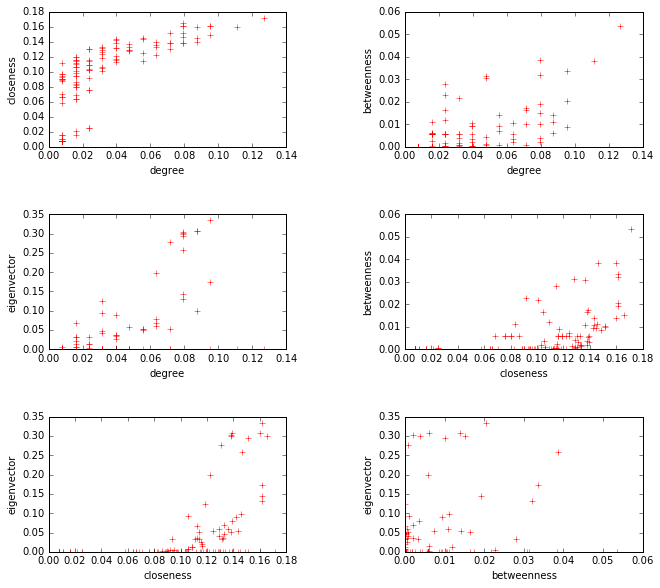

In [12]:
degree_vec_7 = np.array([value for key,value in sorted(degree_centrality_7.items())])
closeness_vec_7 = np.array([value for key,value in sorted(closeness_centrality_7.items())])
betweenness_vec_7 = np.array([value for key,value in sorted(betweenness_centrality_7.items())])
eigenvector_vec_7 = np.array([value for key,value in sorted(eigenvector_centrality_7.items())])

# Now, print all 6 pairwise plots
plt.subplot(321)
plt.subplots_adjust(wspace=.5,hspace=.5, right=1.5, top=2)
plt.plot(degree_vec_7,closeness_vec_7,'r+')
plt.xlabel("degree")
plt.ylabel("closeness")

plt.subplot(322)
plt.plot(degree_vec_7,betweenness_vec_7,'r+')
plt.xlabel("degree")
plt.ylabel("betweenness")

plt.subplot(323)
plt.plot(degree_vec_7,eigenvector_vec_7,'r+')
plt.xlabel("degree")
plt.ylabel("eigenvector")

plt.subplot(324)
plt.plot(closeness_vec_7,betweenness_vec_7,'r+')
plt.xlabel("closeness")
plt.ylabel("betweenness")

plt.subplot(325)
plt.plot(closeness_vec_7,eigenvector_vec_7,'r+')
plt.xlabel("closeness")
plt.ylabel("eigenvector")

plt.subplot(326)
plt.plot(betweenness_vec_7,eigenvector_vec_7,'r+')
plt.xlabel("betweenness")
plt.ylabel("eigenvector")

These graphs have more obvious artifacts--since there are fewer possible connections, there are fewer possible degree centrality values. Here, we see degree centrality matching up much more nicely with eigenvector centrality--we might hypothesize that this is the case because the connections the .7 network dropped were ones with "unimportant" nodes, so there is less of an opportunity for a node to be connected to lots of these, giving high degree and low eigenvector centrality.

### Exercise
We can look at how centrality differs across the networks--which one would we expect has more central nodes? To do this, we will do the following:
1. Choose one of the centrality measures and find its mean value for both networks
2. Plot the two centralities in different colors, and plot each mean in a different color.
3. Change two lines in your code to make it work for a different centrality. How do the results for this one look compared to the other?

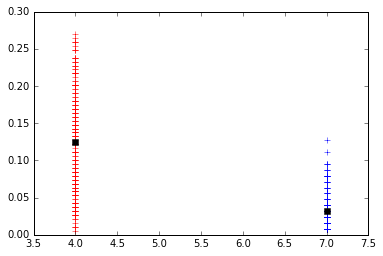

In [13]:
# Choose centrality measure--you can just set this equal to one of our precomputed centrality vectors
my_centrality_4 = degree_vec_4
my_centrality_7 = degree_vec_7

# Compute means
mean_4 = np.mean(my_centrality_4)
mean_7 = np.mean(my_centrality_7)

# Make x vectors so we can plot each measure vertically but not on top of each other, and prepare the mean vector
x_4 = np.ones(len(my_centrality_4)) + 3
x_7 = np.ones(len(my_centrality_7)) + 6
mean_y = np.array([mean_4,mean_7])
mean_x = np.array([4,7])

# Plot it all on one axis

plt.plot(x_4, my_centrality_4, 'r+', x_7, my_centrality_7, 'b+', mean_x, mean_y, 'ks')
plt.xlim([3.5,7.5])
plt.show()

## Miscellaneous network statistics
Networks are very complicated objects, and we can't gain an appreciation for what's going on through a single number. However, there are some statistics that give you an idea about certain properties of a network that you may find useful. Here, we explore a couple, and look at how they differ between the .4 and .7 networks.

First we have network assortativity: the tendency of nodes to connect to nodes of similar degree. We might expect this measure to be lower in "core-perihery" networks: networks where some people act as information hubs and the rest act as receivers of information. We expect it to be low in this case because high-degree hubs associate with low-degree receivers rather than with other hubs. However, in friendship networks, we might expect this number to be higher.

In [14]:
print "Assortativity\t.4 network: %f\t.7 network: %f" %(nx.degree_assortativity_coefficient(G4),nx.degree_assortativity_coefficient(G7))

Assortativity	.4 network: 0.291471	.7 network: 0.321018


So we see that the .7 network is slightly more assortative. This leads credence to our hypothesis before that the .7 network has fewer "unimportant" nodes connecting to high-degree nodes, giving us that interesting pattern in the .4 network's degree vs. eigenvector centrality plot.

Next, we look at transitivity. This is the tendency of network connections to obey the mathematical relationship of transitivity: if A<->B and B<->C, how often does A<->C? It is computed by dividing the total number of complete triangles (i.e., 3-cliques) by the total number of possible triangles (defined as any set of three nodes where A<->B and B<->C)

In [15]:
print "Transitivity\t.4 network: %f\t.7 network: %f" %(nx.transitivity(G4), nx.transitivity(G7))

Transitivity	.4 network: 0.575925	.7 network: 0.477859


We might be interested in how clustered a network is--do nodes tend to connect in compact groups, or randomly associate with nodes at random in the network. We can compute this at a node level using the clustering coefficient, which looks at how many triangles a node is involved in relative to the total number of triangles a node with that degree could be involved in. To get an idea of how clustered the network is overall, we can look at the average clustering coefficient.

Average clustering coefficient	.4 network: 0.537094	.7 network: 0.339985


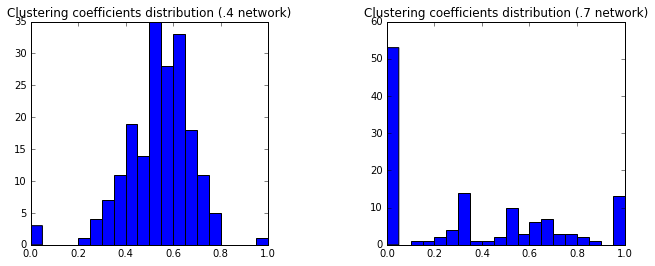

In [16]:
print "Average clustering coefficient\t.4 network: %f\t.7 network: %f" %(nx.average_clustering(G4), nx.average_clustering(G7))

# Let's also plot a histogram of the clustering coefficients for each graph
clust_coefs_4 = np.array(nx.clustering(G4).values())  # nx.clustering() returns a dict, so we just take its values
clust_coefs_7 = np.array(nx.clustering(G7).values())
fig, axs = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=.5, right=1.5)
axs[0].hist(clust_coefs_4, bins=20)
axs[0].set_title("Clustering coefficients distribution (.4 network)")
axs[1].hist(clust_coefs_7, bins=20)
axs[1].set_title("Clustering coefficients distribution (.7 network)")
plt.show()

It shouldn't surprise us that the .4 network is more clustered than the .7 network--since it's so much more tense, there is a much greater opportunity for clusters to emerge.

Finally, we might want to know the degrees of separation for this network: what's the longest path you'd have to take to navigate between the two furthest-apart nodes? 
NOTE: We only do this for the .4 network--since the .7 network isn't fully connected, it has an infinite diameter and throws an error.

In [17]:
print "Diameter\t.4 network: " + str(nx.diameter(G4))

Diameter	.4 network: 5


### Exercise
The network diameter is the longest shortest path in the whole network, but there is an analogous node-level statistic called eccentricity--the shortest path you can take to get from this node to the node furthest away. 
1. First, plot a histogram of the eccentricities of the network. This histogram looks a little different from the others we've seen--what does it tell us about the network? Note: the function you want to use is nx.eccentricities(), but this will return a dict, not a vector, so you will have to convert it in the same way I did above for centralities.
2. We might expect that a node's eccentricity might be related to its closeness centrality, which is larger the closer you are to other nodes on average. How would you expect the two to be related? Make a scatterplot of one against the other to see if you can see a trend.

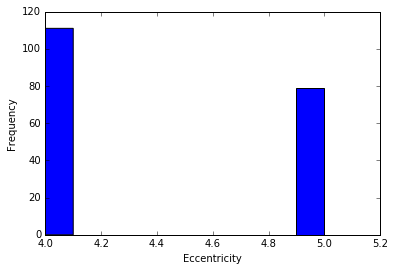

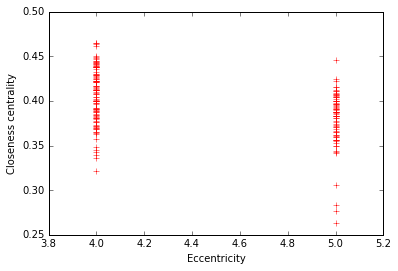

In [18]:
# Calculate eccentricities
eccentricities_dict_4 = nx.eccentricity(G4)
# Turn this dictionary into an array for plotting
eccentricities_vec_4 = np.array([value for key,value in sorted(eccentricities_dict_4.items())])
# Plot a histogram of the eccentricities
plt.hist(eccentricities_vec_4)
plt.xlabel("Eccentricity")
plt.ylabel("Frequency")
plt.show()
# Plot eccentricities against closeness centrality
plt.plot(eccentricities_vec_4, closeness_vec_4, 'r+')
plt.xlabel("Eccentricity")
plt.ylabel("Closeness centrality")
plt.xlim([3.8,5.2])
plt.show()

## Clustering
Can our nodes be split into groups that tend to interact within the group and not without? What do these clusters look like? For this section, we will go back to the original correlation matrix: network clustering algorithms take a matrix of differences between nodes as input and reports a clustering as output. Typically, clustering algorithms require the user to choose a number of clusters they would like to split their data into.
For this exercise, we will use an algorithm called <b>spectral clustering</b>, which takes a similarity matrix (like our correlation matrix), embeds the nodes into a low-dimensional space, and clusters them in that space. Try using different numbers of clusters  and see 

Number of nodes in each cluster
Cluster 0: 45
Cluster 1: 62
Cluster 2: 40
Cluster 3: 43


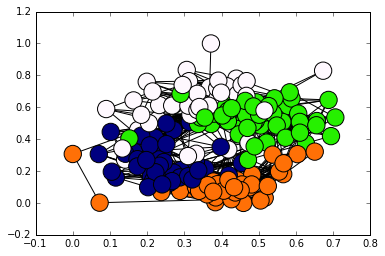

In [19]:
# First, let's remove negatives from our correlation matrix and set them equal to 0.
thresh_net = np_network.copy()
thresh_net[thresh_net < 0] = 0

n_clusters = 4
spectral = cluster.SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
clusts = spectral.fit_predict(thresh_net)
np.random.seed(11)

print "Number of nodes in each cluster"
for clust in xrange(n_clusters):
    print "Cluster %d: %d" %(clust,np.sum(clusts == clust))
    
clust_colors = clusts / float(N)
nx.draw_networkx(G4,with_labels=False, node_color=clust_colors,
                 cmap=plt.get_cmap('gist_ncar'))

We can also look at agglomerative clustering, which starts with every node in its own cluster, and greedily merges clusters together until we have the desired amount. A very important parameter for this algorithm is the linkage, which tells us how to combine clusters. Do we want to combine two clusters together if on average, the nodes in one cluster are close to those in the other ("average"), if the node in cluster 1 that is furthest away from any node in cluster 2 is still pretty close ("complete"), or if the resultant cluster will be low-variance ("ward")?

Note that this algorithm, unlike the last, doesn't take a similarity matrix: it takes a feature matrix (where each row is a node and each column is a "feature"). We can still use our similarity matrix for this, but we will want to amend our correlation matrix to make each node close to itself.

Number of nodes in each cluster
Cluster 0: 57
Cluster 1: 87
Cluster 2: 24
Cluster 3: 22


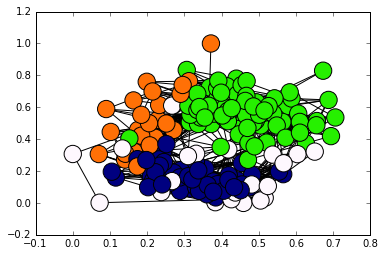

In [20]:
# First, put ones along the diagonal of the thresh_net, to indicate that each node is perfectly correlated with itself
thresh_net_with_diag = thresh_net + np.diag(np.ones(N)) 

n_clusters = 4
linkage = "average"
agg = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
agg_clusts = agg.fit_predict(thresh_net_with_diag)

print "Number of nodes in each cluster"
for clust in xrange(n_clusters):
    print "Cluster %d: %d" %(clust,np.sum(agg_clusts == clust))

np.random.seed(11)
clust_colors = agg_clusts / float(N)
nx.draw_networkx(G4,with_labels=False, node_color=clust_colors,
                 cmap=plt.get_cmap('gist_ncar'))

### Exercise
We expect that a cluster might have some different properties from the graph as a whole. In this exercise, we'll investigate some of the properties of the sub-network of a single cluster and compare it to the network as a whole.

Average clustering coefficient	.4 network: 0.537094	Cluster: 0.620235
Diameter	.4 network: 5.000000	Cluster: 4.000000


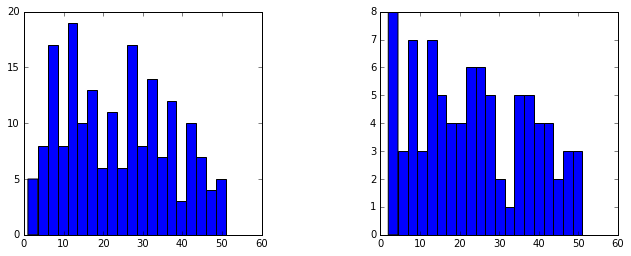

In [21]:
subnetwork_nodes = agg_clusts == 1
subnetwork_graph = thresh_net_4[np.ix_(subnetwork_nodes, subnetwork_nodes)]  # Magic to index graph properly

# Create new graph
G_clust = nx.Graph()
rows,cols = subnetwork_graph.nonzero()
for row,col in izip(rows,cols):  # Note this will add each edge twice, but networkx will just ignore redundant edges
    G_clust.add_edge(row,col)
    
# Degree
degree_clust = nx.degree(G_clust)
degree_arr_clust = np.array(degree_clust.values())

fig, axs = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=.5, right=1.5)
axs[0].hist(degree_arr4, bins=20)
axs[1].hist(degree_arr_clust, bins=20)

# Compute average clustering coefficients
clustering_G4 = nx.average_clustering(G4)
clustering_G_clust = nx.average_clustering(G_clust)
print "Average clustering coefficient\t.4 network: %f\tCluster: %f" %(clustering_G4, clustering_G_clust)

# Now, diameter
diameter_G4 = nx.diameter(G4)
diameter_G_clust = nx.diameter(G_clust)
print "Diameter\t.4 network: %f\tCluster: %f" %(diameter_G4, diameter_G_clust)